In [1]:
import os
import cv2
import tqdm
import pickle
import imageio
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from util.preprocess import *

# Preprocessing scheme for iPhones

Input raw focal stack: (H, W, N)

H = Height
W = Width
N = number of focus positions

Step 1: Absolute Homography Estimation -> for images (H, W)

1. Find (most) in focus image in stack
2. Estimate camera parameters K, radial distortion coefficients D for the most in focus image
3. Map most in focus image to linear perspective with K, D
4. Solve for a homography H that maps linear perspective in focus image to sharp ground truth

Step 2: Relative Homography Estimation -> for images (H,W)

1. Apply radial distortion coefficients D to each channel-separated image (H/2, W/2, 4) in the focal stack. Now, we have a linear perspective focal stack. Make sure to put back into the mosaic before the next step.
2. Find an image scaling-only homography S_i that maps each linear perspective image in the focal stack to the in focus image. 

Step 3: Mapping Sharp Ground Truth P to the RAW Capture Space of Each Image in Focal Stack -> for images (H,W)

1. Map P to in focus image’s linear perspective: P’ = HP
2. Create a sharp linear perspective focal stack: P_i’’ = S_i (HP)
3. Apply radial distortion K, D to P_i’’ to create sharp images in raw capture space
4. Apply radiometry correction with the white+black images taken in lens positions’ raw space

Output (inputs) to training -> for images (H, W)

1. Raw blurry focal stack without any modifications
2. Sharp focal stack mapped to raw capture space



In [2]:
# Directories
trial = "3"
data_dir = f'/scratch/year/lin/blur-fields-dataset/iphone14pro1-wide/t{trial}/processed/'
sharp_dir = f'/scratch/ondemand27/lin/blur-fields/lens-dataset/sharp/iphone/'
save_dir = data_dir+'temp/'
fig_dir = save_dir+'figs/'
print(f"Data directory: {data_dir}")
print(f"Save directory: {save_dir}")

os.makedirs(fig_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [3]:
# Just some initializations for camera calibration
#dot_grid = (6, 8)
dot_grid = (9,12)
neighbourhood_size = 150
dot = dot_grid[0]

In [4]:
# Load in the sharp polka dot pattern
sharp_polka = np.load(sharp_dir + f'calib_patterns/{dot}.npy')

# Get object points
obj_points_h = np.load(sharp_dir + f'calib_patterns/{dot}-centres-h.npy')
obj_points_w = np.load(sharp_dir + f'calib_patterns/{dot}-centres-w.npy')
obj_points = np.stack((obj_points_w, obj_points_h, np.zeros(dot_grid[0]*dot_grid[1])), axis=-1).astype(np.float32)

# Read in patterns and lens positions
with open(data_dir + 'patterns.pickle', 'rb') as f:
    patterns = pickle.load(f)
with open(data_dir + 'lens_positions.pickle', 'rb') as f:
    lens_positions = pickle.load(f)
with open(data_dir + 'api_positions.pickle', 'rb') as f:
    api_positions = pickle.load(f)

In [5]:
print(lens_positions)

[1.         0.90131579 0.82035928 0.75274725 0.6961326  0.6302682
 0.55629139 0.51653944 0.49033816 0.45833333 0.40542206 0.35897436
 0.31421446 0.25682032 0.21281216 0.16502947 0.1107814  0.08063355
 0.06338427 0.05221445]


In [6]:
# Image height and width
height, width = sharp_polka.shape
print(height, width, patterns, api_positions)
print(len(api_positions))

3024 4032 ['6-dots', '6-dots-conjugate', 'black', 'dots', 'dots-conjugate', 'train-10', 'train-100', 'train-20', 'train-50', 'train-70', 'white'] [0.    0.042 0.084 0.126 0.168 0.211 0.253 0.295 0.337 0.379 0.421 0.463
 0.505 0.547 0.589 0.632 0.674 0.716 0.758 0.8  ]
20


In [7]:
# Read in raw data and downsize
blurry_original = np.float32(np.load(data_dir + 'blurry-original.npy'))
print(blurry_original.shape)

(11, 20, 3024, 4032)


In [8]:
# In focus lens positions:
infocus_p = 12

## Step 1: Absolute homography estimation
1. Find (most) in focus image in stack
2. Estimate camera parameters K, radial distortion coefficients D for the most in focus image
3. Map most in focus image to linear perspective with K, D
4. Solve for a homography H that maps linear perspective in focus image to sharp ground truth

In [9]:
# Unforuntately, may have to do some manual cropping at the edges to clean things up...
top = 0
bottom = 1
left = 1
right = 1

(3024, 4032)


Text(0.5, 1.0, 'Cross section of binarized polka dot pattern')

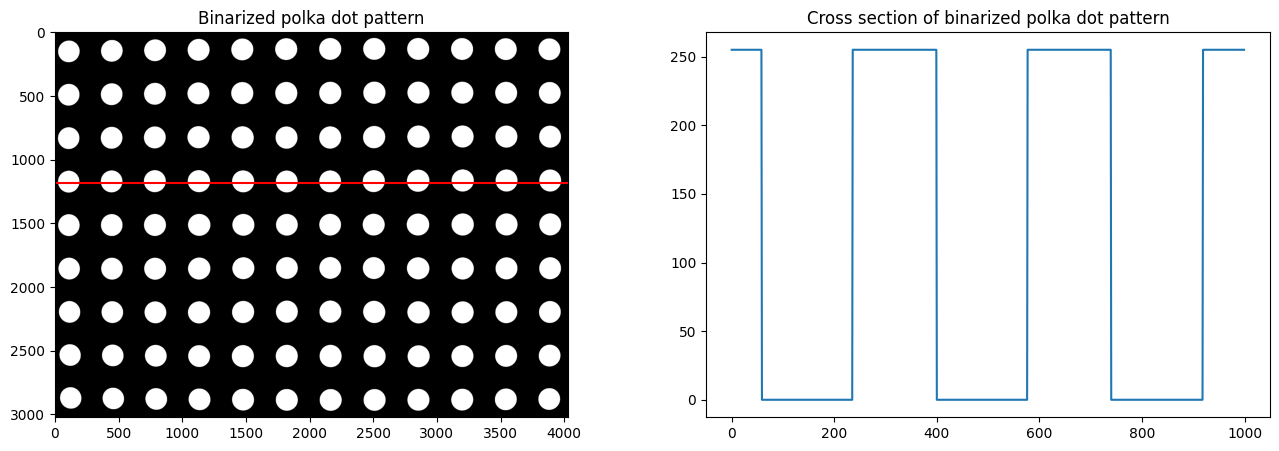

In [10]:
# Let's binarize the polka dot pattern for a better radial distortion correction
binarize_infocus = binarize(
    blurry_original[patterns.index(f'dots'), infocus_p, ...], 
    blurry_original[patterns.index(f'dots-conjugate'), infocus_p, ...]
)
# Unforuntately, may have to do some manual cropping at the edges to clean things up...
binarize_infocus[:top, :] = 0
binarize_infocus[-bottom:, :] = 0
binarize_infocus[:, :left] = 0
binarize_infocus[:, -right:] = 0

# Make a uint8
binarize_infocus = (255*binarize_infocus).astype(np.uint8)
print(binarize_infocus.shape)

# Plot the binarized pattern and it's middle row cross section
# Draw a line corresponding to the cross section on the imshow
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].imshow(binarize_infocus, cmap='gray')
ax[0].axhline(1180, color='r')
ax[0].set_title('Binarized polka dot pattern')
ax[1].plot(binarize_infocus[1198, 1500:2500])
ax[1].set_title('Cross section of binarized polka dot pattern')


In [11]:
# Detect circles in the binarized polka dot pattern
refined_circles = detect_circle_centers_with_subpixel_accuracy(
    cv2.cvtColor(binarize_infocus, cv2.COLOR_GRAY2BGR), 
    dp=1, minDist=320, param1=100, param2=30, 
    minRadius=80, maxRadius=100, 
    neighborhood_size=neighbourhood_size, neighborhood=True
)

# Sort the detected circles
img_points = sort_circles(refined_circles, *dot_grid)
print(refined_circles.shape, img_points.shape, obj_points.shape)


detected circles (1, 108, 3)
(108, 3) (108, 2) (108, 3)


In [12]:
# Let's do some filtering
temp_obj_points = obj_points.copy()
"""
img_points = img_points[img_points[:,1] > 200]
temp_obj_points = temp_obj_points[temp_obj_points[:,1] > 200]

img_points = img_points[img_points[:,1] < 2600]
temp_obj_points = temp_obj_points[temp_obj_points[:,1] < 2600]

img_points = img_points[img_points[:,0] > 200]
temp_obj_points = temp_obj_points[temp_obj_points[:,0] > 200]

img_points = img_points[img_points[:,0] < 3700]
temp_obj_points = temp_obj_points[temp_obj_points[:,0] < 3700]
"""

'\nimg_points = img_points[img_points[:,1] > 200]\ntemp_obj_points = temp_obj_points[temp_obj_points[:,1] > 200]\n\nimg_points = img_points[img_points[:,1] < 2600]\ntemp_obj_points = temp_obj_points[temp_obj_points[:,1] < 2600]\n\nimg_points = img_points[img_points[:,0] > 200]\ntemp_obj_points = temp_obj_points[temp_obj_points[:,0] > 200]\n\nimg_points = img_points[img_points[:,0] < 3700]\ntemp_obj_points = temp_obj_points[temp_obj_points[:,0] < 3700]\n'

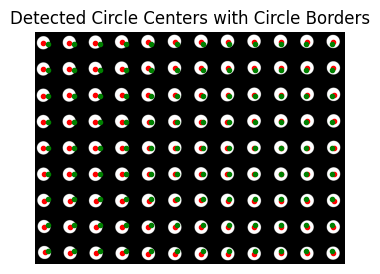

In [13]:
# Plot the binarized pattern and it's middle row cross section
# Draw a line corresponding to the cross section on the imshow
#plt.imshow(binarize_infocus, cmap='gray')
# Display the image with the circle borders
plt.figure(figsize=(4,4))
plt.imshow(binarize_infocus, cmap='gray')
plt.plot(img_points[:,0], img_points[:,1], 'r.')
plt.plot(temp_obj_points[:,0], temp_obj_points[:,1], 'g.')
plt.title('Detected Circle Centers with Circle Borders')
plt.axis('off')
plt.show()

Radial distortion coefficients: [1.9284969238378251, -103.43863502532115, 1462.2060580415862]
Camera Matrix [[1.21698044e+04 0.00000000e+00 2.01310766e+03]
 [0.00000000e+00 1.21616993e+04 1.52304566e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation Vectors (array([[ 0.01923811],
       [ 0.02595454],
       [-0.00155809]]),)
Translation Vectors (array([[-2042.96642978],
       [-1518.77832339],
       [12014.33817806]]),)


Text(0.5, 1.0, 'Difference between undistorted and original image')

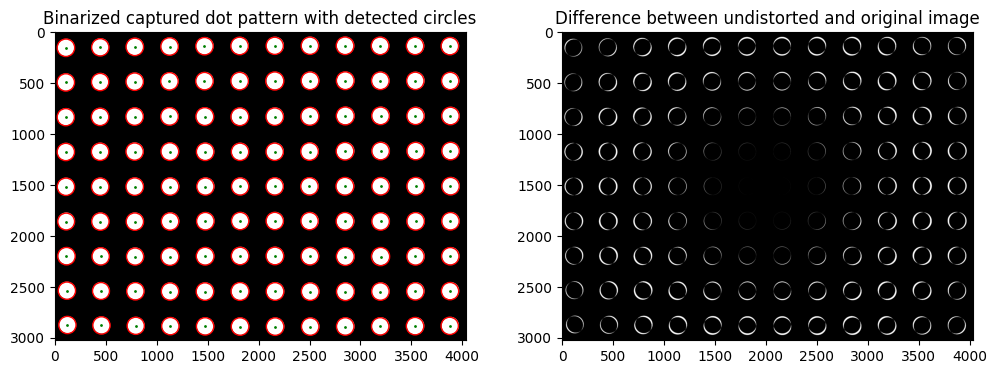

In [14]:
# Get radial distortion coefficients
ret, camera_matrix, dist_coeffs, rvecs, tvecs = calibrate_camera([temp_obj_points], [img_points], binarize_infocus.shape[1], binarize_infocus.shape[0])
radial_coeffs = [dist_coeffs[0,0], dist_coeffs[1,0], dist_coeffs[4,0]]
print('Radial distortion coefficients:', radial_coeffs)
print("Camera Matrix", camera_matrix)
print("Rotation Vectors", rvecs)
print("Translation Vectors", tvecs)

# Undistort the polka dot pattern
linearized_infocus_image = undistort_radial(binarize_infocus, camera_matrix, dist_coeffs) #cv2.undistort(cv2.cvtColor(data[p,d,...], cv2.COLOR_GRAY2BGR), camera_matrix, dist_coeffs)

# Distort the image points to find reprojection error:
redistort_obj_points = distort_points(temp_obj_points[:,:2], camera_matrix, dist_coeffs)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(binarize_infocus, cmap='gray')
ax[0].plot(img_points[:,0], img_points[:,1], 'go', markersize=1)
for circle_center in refined_circles:
    circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False)
    ax[0].add_patch(circle)
ax[0].set_title('Binarized captured dot pattern with detected circles')
ax[1].imshow(np.abs(np.float32(linearized_infocus_image) - np.float32(binarize_infocus)), cmap='gray')
ax[1].set_title('Difference between undistorted and original image')

detected circles (1, 108, 3)
src:  (108, 2) qry:  (108, 2)
Reprojection error: 1.0999644486711517 +/- 0.637006207343324


KeyboardInterrupt: 

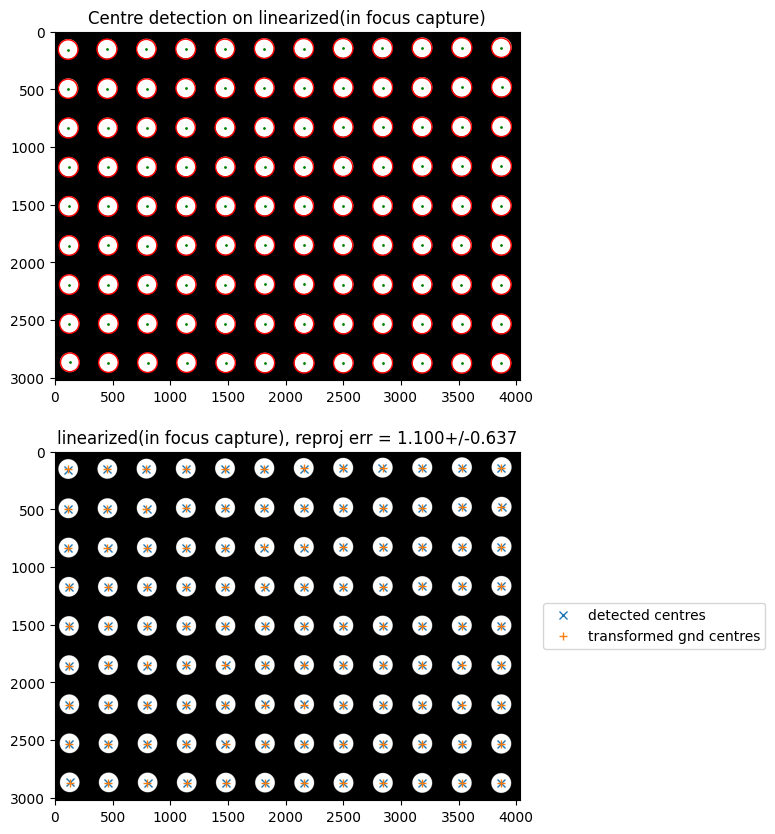

In [15]:
# Solve for a homography that maps the linearized in focus image to the polka dot pattern

# first, need to detect centres again
# Detect circles in the binarized polka dot pattern
refined_circles = detect_circle_centers_with_subpixel_accuracy(
    cv2.cvtColor(linearized_infocus_image, cv2.COLOR_GRAY2BGR), 
    dp=1, minDist=300, param1=100, param2=30, 
    minRadius=80, maxRadius=100, 
    neighborhood_size=neighbourhood_size, neighborhood=True
    )

# Sort the detected circles
img_points = sort_circles(refined_circles, dot_grid[0], dot_grid[1])

# Do some filtering
"""
img_points = img_points[img_points[:,1] > 200]
temp_obj_points = temp_obj_points[temp_obj_points[:,1] > 200]

img_points = img_points[img_points[:,1] < 2600]
temp_obj_points = temp_obj_points[temp_obj_points[:,1] < 2600]

img_points = img_points[img_points[:,0] > 200]
temp_obj_points = temp_obj_points[temp_obj_points[:,0] > 200]

img_points = img_points[img_points[:,0] < 3700]
temp_obj_points = temp_obj_points[temp_obj_points[:,0] < 3700]
"""

# Get homography
sharp_coords_linearized_infocus, H, invH, _, _ = apply_homography(temp_obj_points, img_points, sharp_polka, thresh=10.0)
reprojection_err, std_err, transformed_coords = reprojection_error(temp_obj_points[:,:2], img_points, invH)
print(f'Reprojection error: {reprojection_err} +/- {std_err}')

# plot the transformed_coords on top of obj_points
fig, ax = plt.subplots(2,1, figsize=(6,10))
ax[0].imshow(sharp_coords_linearized_infocus, cmap='gray')
ax[0].plot(img_points[:,0], img_points[:,1], 'go', markersize=1)
for circle_center in refined_circles:
    circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False)
    ax[0].add_patch(circle)
ax[0].set_title('Centre detection on linearized(in focus capture)')
ax[1].imshow(sharp_coords_linearized_infocus, cmap='gray')
ax[1].plot(img_points[:,0], img_points[:,1], 'x', markersize=6, label='detected centres')
ax[1].plot(transformed_coords[:,0], transformed_coords[:,1], '+', markersize=6, label='transformed gnd centres')
ax[1].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
ax[1].set_title('linearized(in focus capture), reproj err = {:.3f}+/-{:.3f}'.format(reprojection_err, std_err))
fig.savefig(fig_dir+'linearized_infocus_reproj_err.pdf', bbox_inches='tight', dpi=300)


In [ ]:
# Let's do the opposite now
# Map the polka dot pattern to the linearized in focus image
# use H
# Warp the image
gnd_infocus_linear_perspective = cv2.warpPerspective(
    sharp_polka,invH,(width, height),
    flags=(cv2.INTER_LINEAR), 
    borderMode=cv2.BORDER_CONSTANT, 
    borderValue = [0,0,0,0])


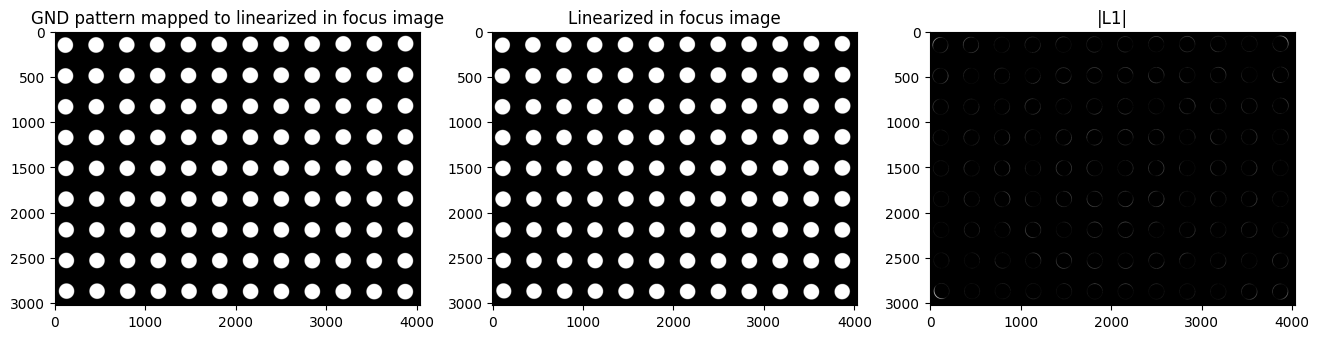

In [ ]:
# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(norm_img(np.abs(norm_img(gnd_infocus_linear_perspective) - norm_img(linearized_infocus_image))), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')
fig.savefig(fig_dir+'linearized_infocus_reproj.pdf', bbox_inches='tight', dpi=300)

## Step 2: Relative Homography Estimation -> for images (H,W)

1. Apply radial distortzion coefficients D to each image in the focal stack. Now, we have a linear perspective focal stack. 
2. Find an image scaling-only homography S_i that maps each linear perspective image in the focal stack to the in focus image. 

In [ ]:
linearized_focal_stack = np.zeros((2, len(lens_positions), height, width))
binarized_linearized_focal_stack = np.zeros((len(lens_positions), height, width), dtype=np.uint8)

for ind_p in range(len(lens_positions)):
    # Undistort the polka dot pattern
    linearized_focal_stack[0,ind_p,...] = undistort_radial(np.float32(blurry_original[patterns.index(f'dots'), ind_p, ...]), camera_matrix, dist_coeffs) 
    linearized_focal_stack[1,ind_p,...] = undistort_radial(np.float32(blurry_original[patterns.index(f'dots-conjugate'), ind_p, ...]), camera_matrix, dist_coeffs) 

    # Let's binarize the polka dot pattern for a better radial distortion correction
    binarized = binarize(
        linearized_focal_stack[0, ind_p, ...], 
        linearized_focal_stack[1, ind_p, ...]
    )
    # Unforuntately, may have to do some manual cropping at the edges to clean things up...
    binarized[:top, :] = 0
    binarized[-bottom:, :] = 0
    binarized[:, :left] = 0
    binarized[:, -right:] = 0

    # Make a uint8
    binarized = (255*binarized).astype(np.uint8)
    binarized_linearized_focal_stack[ind_p,...] = binarized


Text(0.5, 0.98, 'Difference between each image in the linearized focal stack and the linearized in focus image')

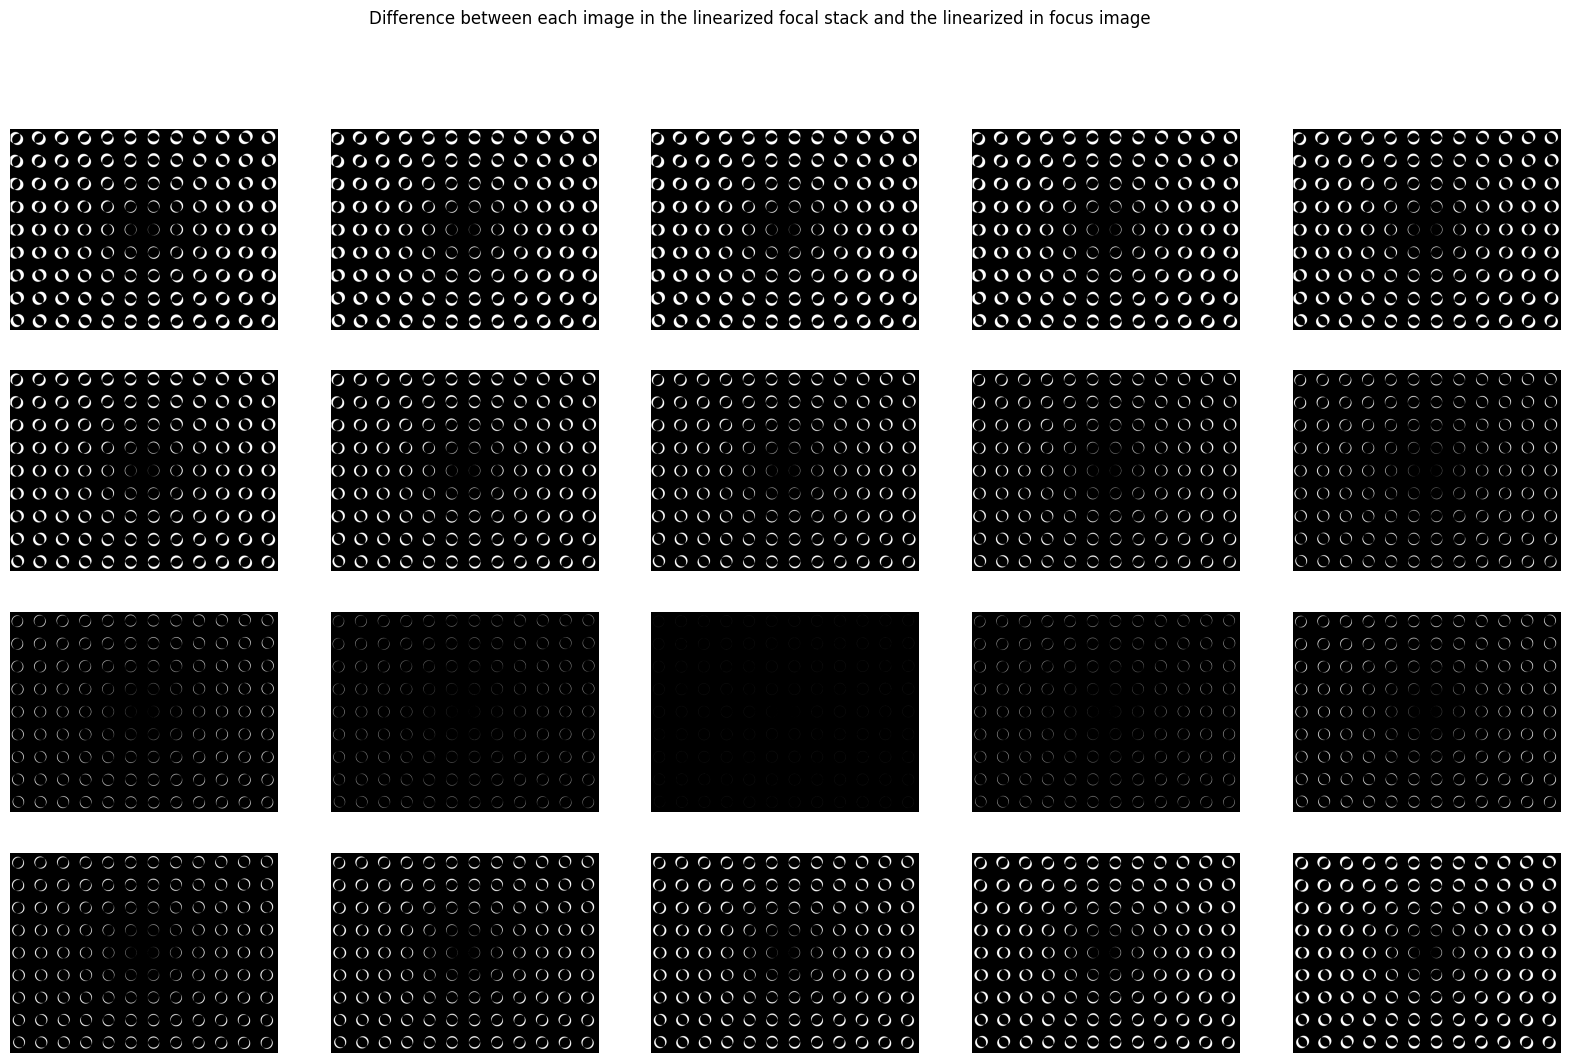

In [ ]:
# Plot in two rows the difference between each image in the linearized focal stack and the linearized in focus image
fig, ax = plt.subplots(4, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(
        norm_img(binarized_linearized_focal_stack[ind_p,...]) - norm_img(linearized_infocus_image)
        ), cmap='gray')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle("Difference between each image in the linearized focal stack and the linearized in focus image")

In [ ]:
# Binarize each image in the linearized focal stack
img_points = np.zeros((len(lens_positions), dot_grid[0]*dot_grid[1], 2))
refined_points = np.zeros((len(lens_positions), dot_grid[0]*dot_grid[1], 3))
for ind_p in range(len(lens_positions)):
    # Detect circles in the binarized polka dot pattern
    refined_circles = detect_circle_centers_with_subpixel_accuracy(
        cv2.cvtColor(binarized_linearized_focal_stack[ind_p,...], cv2.COLOR_GRAY2BGR), 
        dp=1, minDist=300, param1=100, param2=24,
        minRadius=80, maxRadius=100, 
        neighborhood_size=neighbourhood_size, neighborhood=True
    )
    refined_points[ind_p,...] = refined_circles[...]
    # Sort the detected circles
    img_points[ind_p,...] = sort_circles(refined_circles, *dot_grid)


detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)


In [ ]:
# Plot in two rows the difference between each image in the linearized focal stack and the linearized in focus image
fig, ax = plt.subplots(4, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(binarized_linearized_focal_stack[ind_p,...]-binarized_linearized_focal_stack[infocus_p,...]), cmap='gray')
    ax[ind_p//5, ind_p%5].plot(img_points[ind_p,:,0], img_points[ind_p,:,1], 'x-', markersize=6, label='detected circles')
    ax[ind_p//5, ind_p%5].plot(img_points[infocus_p,:,0], img_points[infocus_p,:,1], 'x-', markersize=6, label='infocus circles')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle("Detected Centres for each linearized image in focal stack")
fig.savefig(fig_dir+'linearized_focal_stack_detected_circles-scale.pdf', bbox_inches='tight', dpi=300)
plt.close()

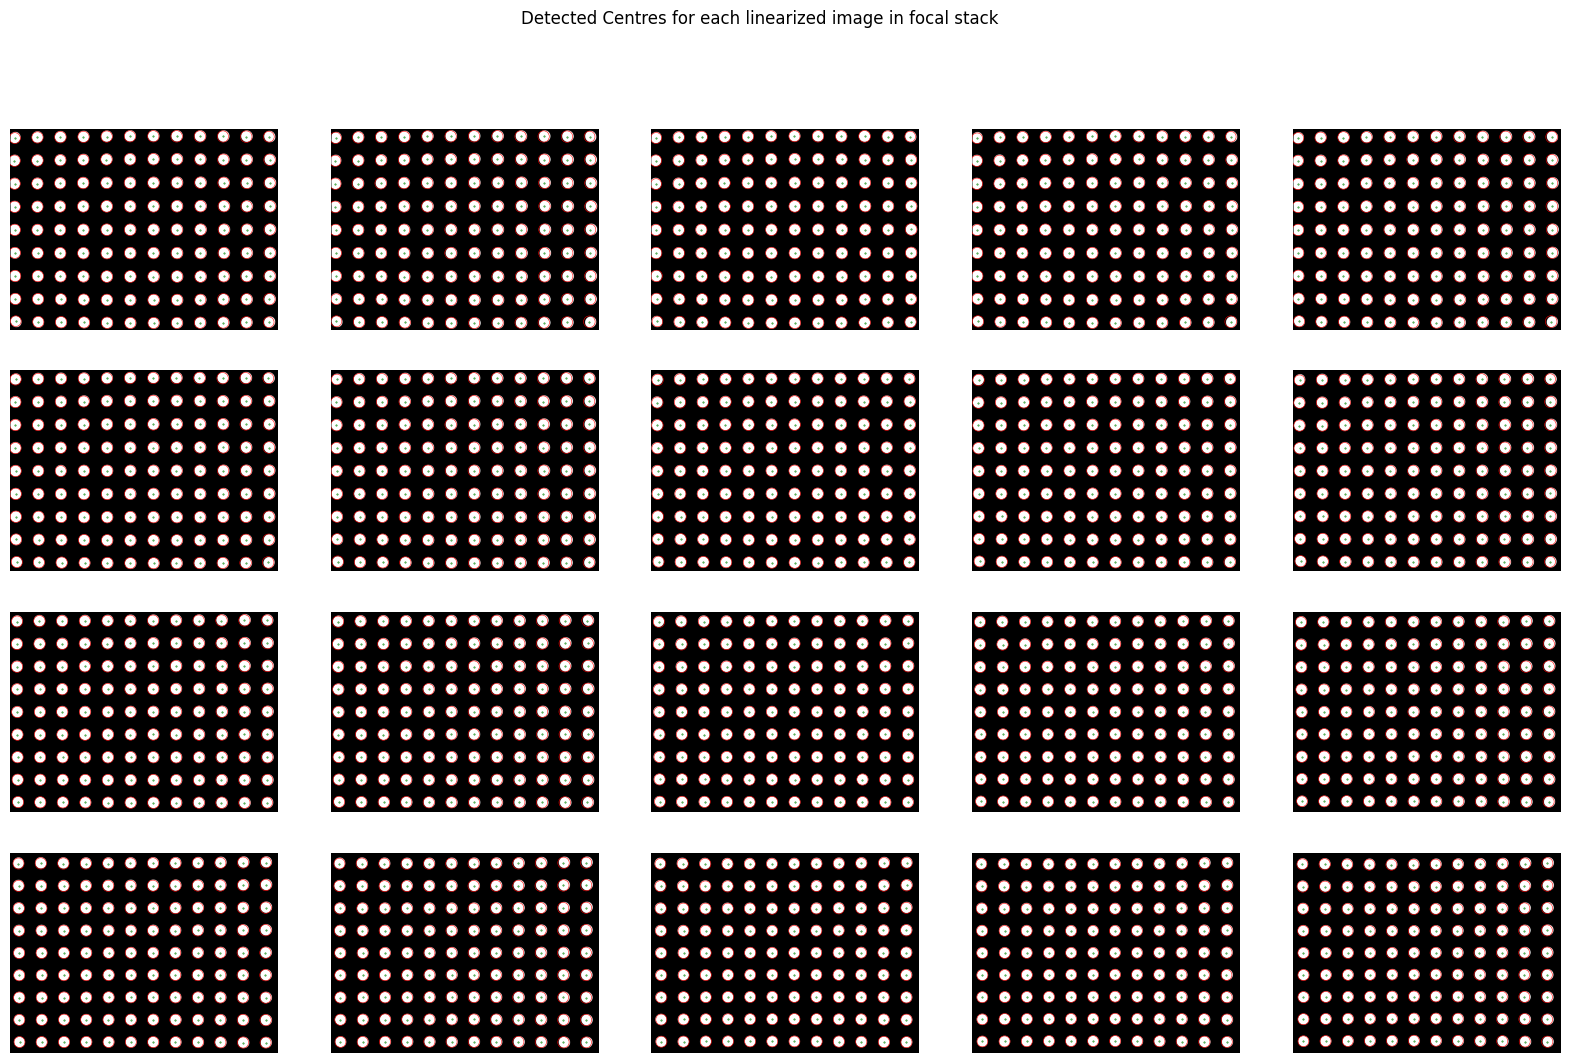

In [ ]:
# Plot in two rows the difference between each image in the linearized focal stack and the linearized in focus image
fig, ax = plt.subplots(4, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(binarized_linearized_focal_stack[ind_p,...], cmap='gray')
    ax[ind_p//5, ind_p%5].plot(refined_points[ind_p, :,0], refined_points[ind_p, :,1], 'go', markersize=0.4)
    ax[ind_p//5, ind_p%5].axis('off')

    for i in range(refined_points.shape[1]):
        circle_center = refined_points[ind_p,i,...]
        circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False, linewidth=0.4)
        ax[ind_p//5, ind_p%5].add_patch(circle)

fig.suptitle("Detected Centres for each linearized image in focal stack")
fig.savefig(fig_dir+'linearized_focal_stack_detected_circles.pdf', bbox_inches='tight', dpi=300)


In [ ]:
# Let's try to map the sharp polka to the linearized in focus image, then use scale to map it to individual linearized images
# find the centre from the principal point
center_x, center_y = camera_matrix[0,2], camera_matrix[1,2] 

In [ ]:
# Find scale factor between each image in the linearized focal stack and the linearized in focus image
scale_factor_avg = np.zeros((len(lens_positions)))
scale_factor_std = np.zeros((len(lens_positions)))
scaleH = np.zeros((len(lens_positions), 3, 3))
for ind_p in range(len(lens_positions)):
    temp_img_points = img_points[ind_p,...] - np.array([center_x, center_y])
    temp_infocus_points = img_points[infocus_p,...] - np.array([center_x, center_y])
    temp = np.divide(temp_infocus_points.reshape(1,-1), temp_img_points.reshape(1,-1))
    scale_factor_avg[ind_p], scale_factor_std[ind_p] = temp.mean(), temp.std()
    scaling_matrix = np.array([
        [scale_factor_avg[ind_p], 0, 0],
        [0, scale_factor_avg[ind_p], 0],
        [0, 0, 1]
    ])


    # Translate the image to the center
    translation_matrix = np.array([
        [1, 0, -center_x * (scale_factor_avg[ind_p] - 1)],
        [0, 1, -center_y * (scale_factor_avg[ind_p] - 1)],
        [0, 0, 1]
    ])

    # Combine the scaling and translation matrices
    scaleH[ind_p] = np.dot(translation_matrix, scaling_matrix)

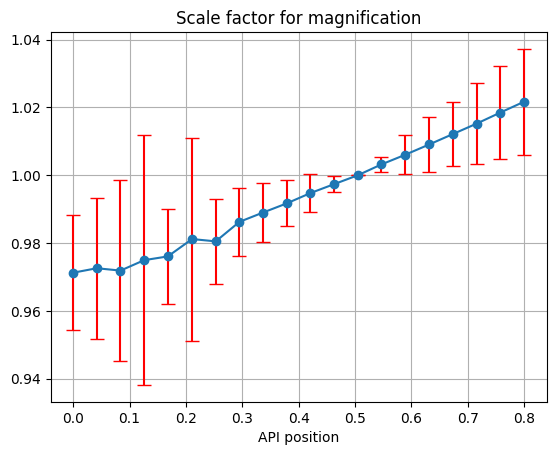

In [ ]:
plt.errorbar(api_positions, scale_factor_avg, yerr=scale_factor_std, fmt='-o', ecolor='red', capsize=5)
plt.grid('on')
plt.title("Scale factor for magnification")
plt.xlabel("API position")
plt.savefig(fig_dir+'scale_factor.pdf', bbox_inches='tight', dpi=300)
np.save(data_dir+'scale.npy', scale_factor_avg)

In [ ]:
gnd_linear_perspective_stack = np.zeros((len(lens_positions), height, width))
for ind_p in range(len(lens_positions)):
    # Scale the mapped sharp polka to the linearized in focus image to the linearized image
    gnd_linear_perspective = cv2.warpPerspective(
        gnd_infocus_linear_perspective,np.linalg.inv(scaleH[ind_p]),(width, height),
        flags=(cv2.INTER_LINEAR), 
        borderMode=cv2.BORDER_CONSTANT, 
        borderValue = [0,0,0,0])

    gnd_linear_perspective_stack[ind_p, ...] = gnd_linear_perspective

Text(0.5, 1.0, 'GND pattern mapped to linearized in focus image')

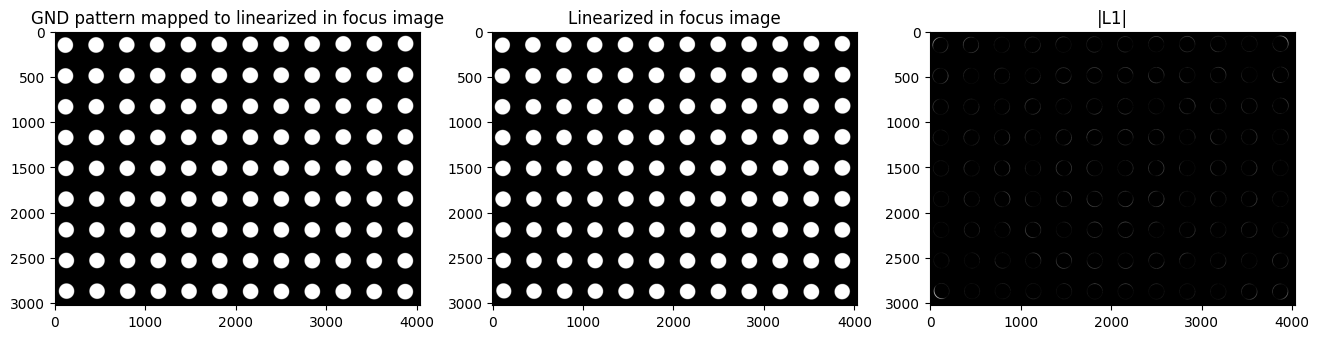

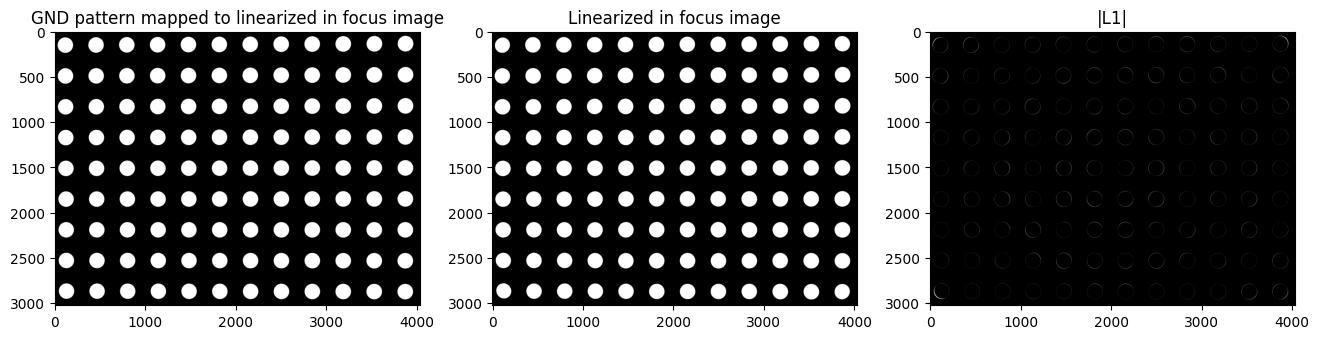

In [ ]:
# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(np.abs(np.float32(gnd_infocus_linear_perspective) - norm_img(linearized_infocus_image)), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')

# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(np.abs(norm_img(gnd_linear_perspective_stack[infocus_p,...]) - norm_img(binarized_linearized_focal_stack[infocus_p, ...])), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')

In [ ]:
gnd_linear_perspective_stack.shape, linearized_focal_stack.shape

((20, 3024, 4032), (2, 20, 3024, 4032))

In [ ]:
# Compare the gnd_linear_perspective_stack with the linearized_focal_stack
fig, ax = plt.subplots(4, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(
        norm_img(gnd_linear_perspective_stack[ind_p, ...]) - norm_img(binarized_linearized_focal_stack[ind_p, ...])
        ), cmap='gray')
    ax[ind_p//5, ind_p%5].axis('off')
    

## Step 3: Mapping Sharp Ground Truth P to the RAW Capture Space of Each Image in Focal Stack -> for images (H,W)

1. Map P to in focus image’s linear perspective: P’ = HP
2. Create a sharp linear perspective focal stack: P_i’’ = S_i (HP)
3. Apply radial distortion K, D to P_i’’ to create sharp images in raw capture space
4. Apply radiometry correction with the white+black images taken in lens positions’ raw space


In [ ]:
# For every images in the linearized gnd focal stack, add radial distortion to the image
# And then add radiometry correction with the white and blacks

radial_distorted_gnd_linear_perspective_stack = np.zeros((len(lens_positions), height, width))
for ind_p in tqdm.tqdm(range(len(lens_positions))):
    map_x, map_y = np.meshgrid(np.arange(width), np.arange(height))
    map_xy = np.stack((map_x, map_y), axis=-1).astype(np.float32)
    distorted_map_xy = distort_points(map_xy, camera_matrix, dist_coeffs)

    distorted_map_x = distorted_map_xy[..., 0].astype(np.float32)
    distorted_map_y = distorted_map_xy[..., 1].astype(np.float32)

    temp = cv2.remap(
        gnd_linear_perspective_stack[ind_p, ...], 
        distorted_map_x, 
        distorted_map_y, 
        cv2.INTER_LINEAR
    )
    # Add radiometry correction by multiplying by the whites
    radial_distorted_gnd_linear_perspective_stack[ind_p, ...] = np.multiply(temp, blurry_original[patterns.index('white'), ind_p,...]) + \
        np.multiply(1-temp, blurry_original[patterns.index('black'), ind_p,...])


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


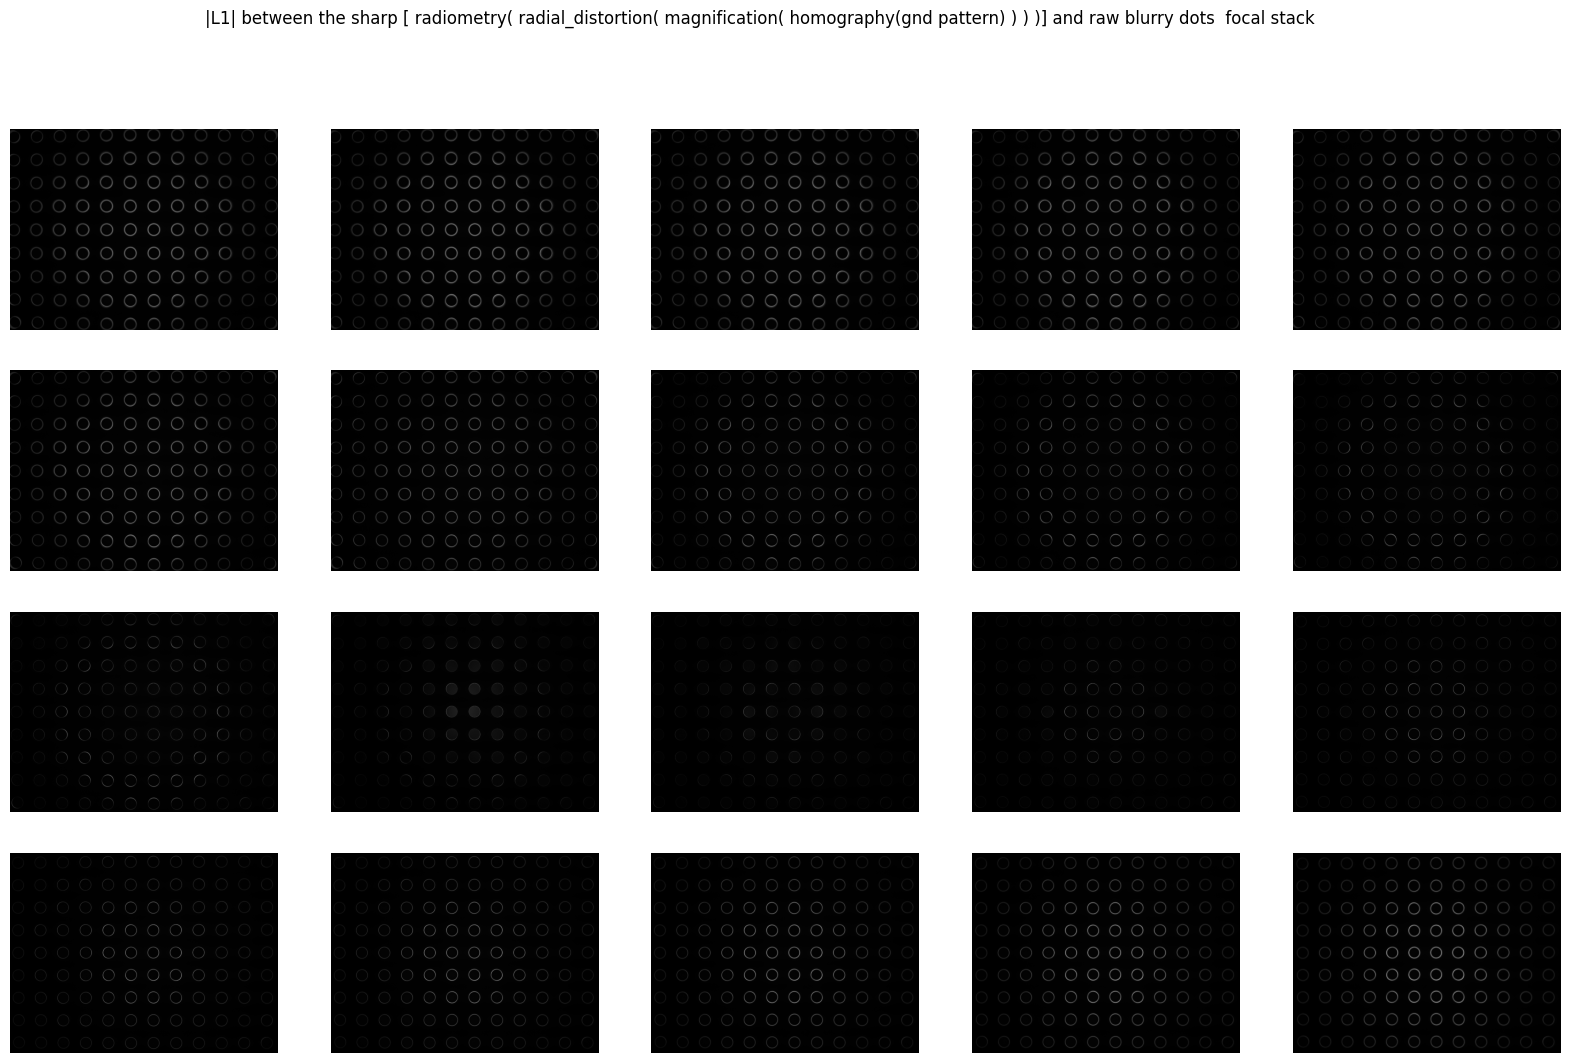

In [ ]:
# Compare the gnd_linear_perspective_stack with the linearized_focal_stack
fig, ax = plt.subplots(4, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(
        norm_img(radial_distorted_gnd_linear_perspective_stack[ind_p, ...]) - norm_img(blurry_original[patterns.index('dots'), ind_p,...])
        ), cmap='gray')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle('|L1| between the sharp [ radiometry( radial_distortion( magnification( homography(gnd pattern) ) ) )] and raw blurry dots  focal stack')
fig.savefig(fig_dir+'|L1| between the sharp [ radiometry( radial_distortion( magnification( homography(gnd pattern) ) ) )]', bbox_inches='tight', dpi=300)

## Step 4: Let's do this for the entire set of patterns
1. Map each pattern to linear perspective of in focus


In [ ]:
# Step 0: read in all of the sharp patterns
sharp_patterns = []
for pat in patterns:
    # read in the imafr from sharp_dir using imageio

    try:
        freq = pat.split('-')[-1]
        if 'test' in pat:
            image = np.float32(imageio.imread(f'{sharp_dir}test_patterns/freq-{freq}.png'))
        elif 'train' in pat:
            image = np.float32(imageio.imread(f'{sharp_dir}train_patterns/freq-{freq}.png'))
        else:
            image = np.ones((height, width))
        sharp_patterns.append(norm_img(image))
    except:
        print("Couldn't read: ", pat)
        sharp_patterns.append(np.ones((height, width)))
sharp_patterns = np.array(sharp_patterns)
print(sharp_patterns.shape)

/tmp/ipykernel_2031982/3428645636.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.float32(imageio.imread(f'{sharp_dir}train_patterns/freq-{freq}.png'))


(11, 3024, 4032)


In [ ]:
# Step 1: Map to the linearized in focus image coords
full_gnd_infocus_linear_perspective = np.zeros((len(patterns), height, width))
for pat in tqdm.tqdm(range(len(patterns))):
    full_gnd_infocus_linear_perspective[pat,...] = cv2.warpPerspective(
        sharp_patterns[pat,...],invH,(width, height),
        flags=(cv2.INTER_LINEAR), 
        borderMode=cv2.BORDER_CONSTANT, 
        borderValue = [0,0,0,0])

100%|██████████| 11/11 [00:00<00:00, 11.86it/s]


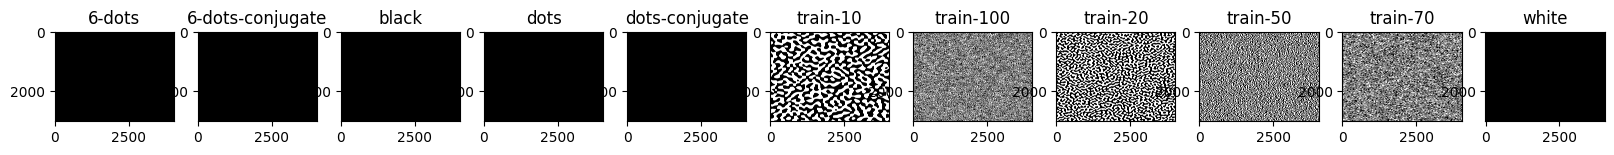

In [ ]:
# Plot all od the sharp patterns in full_gnd_infocus_linear_perspective
fig, ax = plt.subplots(1, len(patterns), figsize=(20,4))
for pat in range(len(patterns)):
    ax[pat].imshow(full_gnd_infocus_linear_perspective[pat,...], cmap='gray')
    ax[pat].set_title(patterns[pat])

In [ ]:
# Prepare for radial distortion
map_x, map_y = np.meshgrid(np.arange(width), np.arange(height))
map_xy = np.stack((map_x, map_y), axis=-1).astype(np.float32)
distorted_map_xy = distort_points(map_xy, camera_matrix, dist_coeffs)

distorted_map_x = distorted_map_xy[..., 0].astype(np.float32)
distorted_map_y = distorted_map_xy[..., 1].astype(np.float32)

In [ ]:
# Prepare for radiometry
radio = np.zeros((2, blurry_original.shape[1], height, width, 4))

# Have a version that is the stacked so that the colour channels are separated
for ind_pat, pat in enumerate(['black', 'white']):
    for ind_p in range(len(lens_positions)):
        radio[ind_pat, ind_p, ...,0] = cv2.resize(
            blurry_original[patterns.index(pat),ind_p,...,0::2,0::2], 
            (width, height), 
            interpolation=cv2.INTER_AREA
        )
        radio[ind_pat, ind_p, ...,1] = cv2.resize(
            blurry_original[patterns.index(pat),ind_p,...,1::2,0::2], 
            (width, height), 
            interpolation=cv2.INTER_AREA
        )
        radio[ind_pat, ind_p, ...,2] = cv2.resize(
            blurry_original[patterns.index(pat),ind_p,...,0::2,1::2], 
            (width, height), 
            interpolation=cv2.INTER_AREA
        )
        radio[ind_pat, ind_p, ...,3] = cv2.resize(
            blurry_original[patterns.index(pat),ind_p,...,1::2,1::2], 
            (width, height), 
            interpolation=cv2.INTER_AREA
        )

In [ ]:
training_patterns = [pat for pat in patterns if 'train' in pat and '120' not in pat] 

#test_patterns = [pat for pat in patterns if 'test' in pat]
training_patterns

['train-10', 'train-100', 'train-20', 'train-50', 'train-70']

In [ ]:
# Let's get the final result
full_gnd_final_stack = np.zeros((len(training_patterns), len(lens_positions), height, width, 4))
blurry_down = np.zeros((len(training_patterns), len(lens_positions), height, width))
for ind_pat, pat in tqdm.tqdm(enumerate(training_patterns)):
    for ind_p in range(len(lens_positions)):
        # Step 2: Map to invidual homography scalings
        gnd_linear_perspective = cv2.warpPerspective(
            full_gnd_infocus_linear_perspective[patterns.index(pat),...],np.linalg.inv(scaleH[ind_p]),(width, height),
            flags=(cv2.INTER_LINEAR), 
            borderMode=cv2.BORDER_CONSTANT, 
            borderValue = [0,0,0,0])

        # Step 3: Apply radial distortion
        temp = cv2.remap(
            gnd_linear_perspective, 
            distorted_map_x, 
            distorted_map_y, 
            cv2.INTER_LINEAR
        )
        temp_stack = np.stack([temp for i in range(4)], axis=-1)

        # Step 4: Add radiometry correction by multiplying by the whites
        radio_corrected = np.multiply(temp_stack, radio[1, ind_p,...]) + \
            np.multiply(1-temp_stack, radio[0, ind_p,...])

        # Save the bayer stack
        full_gnd_final_stack[ind_pat, ind_p, ...] = radio_corrected
        blurry_down[ind_pat, ind_p, ...] = blurry_original[patterns.index(pat),ind_p,...]


5it [02:39, 31.92s/it]


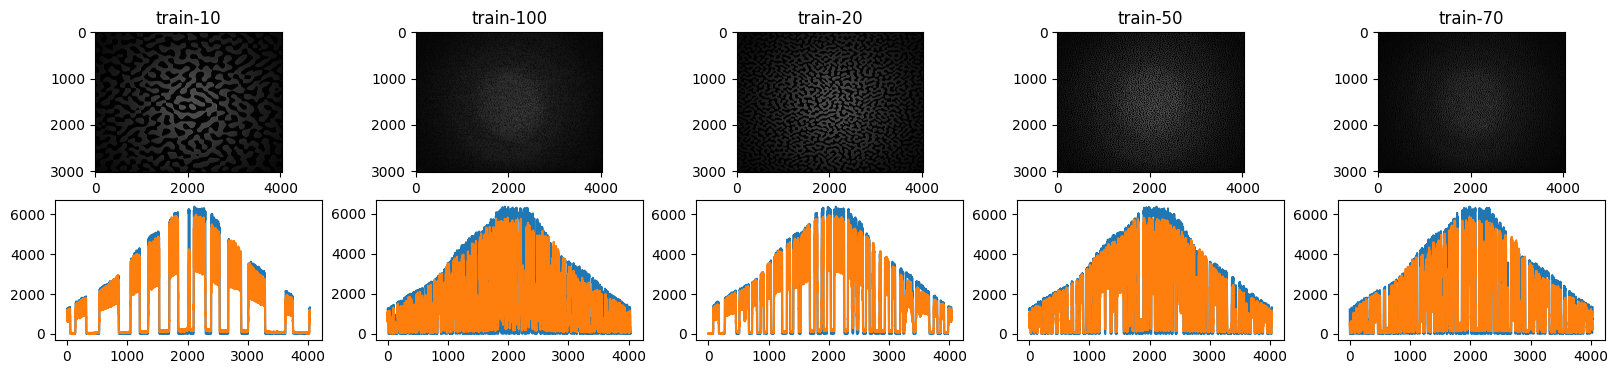

In [ ]:
fig, ax = plt.subplots(2, len(training_patterns), figsize=(20,4))
ind_p = 12
for ind_pat, pat in enumerate(training_patterns):
    ax[0,ind_pat].imshow(np.abs(full_gnd_final_stack[ind_pat, ind_p, ...,1] - blurry_down[ind_pat, ind_p, ...]), cmap='gray')
    ax[0,ind_pat].set_title(pat)
    ax[1,ind_pat].plot(full_gnd_final_stack[ind_pat, ind_p, 1512,:,1])
    ax[1,ind_pat].plot(blurry_down[ind_pat, ind_p, 1512,:])
fig.savefig(fig_dir+'trainingdata.pdf', bbox_inches='tight', dpi=300)

In [ ]:
pat = patterns.index('train-10')
ind_p = 0

for pat in range(len(training_patterns)):
    print(pat, patterns[pat], full_gnd_final_stack[pat, ...].min(), full_gnd_final_stack[pat, ...].max(), blurry_down[pat, ...].min(), blurry_down[pat, ...].max())

0 6-dots 0.0 8088.0 0.0 7928.0
1 6-dots-conjugate 0.0 7992.0 0.0 10016.0
2 black 0.0 8256.0 0.0 9800.0
3 dots 0.0 8256.0 0.0 9800.0
4 dots-conjugate 0.0 8240.0 0.0 10104.0


In [ ]:
# Save everything
full_gnd_final_stack = np.float16(full_gnd_final_stack)
np.save(save_dir+'sharp.npy', full_gnd_final_stack)

blurry_down = np.float16(blurry_down)
np.save(save_dir+'blurry.npy', blurry_down)

# Pickle save these: lens positions, patterns
with open(save_dir + 'train_patterns.pickle', 'wb') as f:
    pickle.dump(training_patterns, f)